# RSA on MEG data with MNE python

This notebook demonstrates how to compute RDM movies from temporal data in MNE and identify significant temporal clusters of data-model RDM correlations.

### Steps:

1) load MNE epoched data (```mne.epochs.Epochs```)

    a) loading, downsampling, epoching, equalizing event count    
    b) simulate multiple subjects from single subject
    
2) import epoched data into rsatoolbox (```mne.epochs.Epochs```  $\rightarrow$ ```rsatoolbox.data.TemporalDataset```)
3) compute RDM movie (```rsatoolbox.data.TemporalDataset``` $\rightarrow$ ```rsatoolbox.rdm.rdms.RDMs```)
4) evaluate RDM movie similarity to model RDMs (```rsatoolbox.rdm.rdms.RDMs``` $\rightarrow$ ```rsatoolbox.inference.result.Result```)
5) compute cluster-based permutation statistic (```rsatoolbox.inference.result.Result``` $-\text{mne.stats.permutation\_cluster\_1samp\_test}\rightarrow$ inference results)


In [1]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories

import sys
sys.path.append('..')
import rsatoolbox
from rsatoolbox.vis.timecourse import plot_timecourse

## 1 Load MNE epoched data

This step follows the first steps of [https://mne.tools/dev/auto_examples/decoding/decoding_rsa_sgskip.html#sphx-glr-auto-examples-decoding-decoding-rsa-sgskip-py](https://mne.tools/dev/auto_examples/decoding/decoding_rsa_sgskip.html#sphx-glr-auto-examples-decoding-decoding-rsa-sgskip-py)

### 1a) loading, downsampling, epoching, equalizing event count

In [2]:
data_path = visual_92_categories.data_path()

In [3]:
# Define stimulus - trigger mapping
fname = data_path / 'visual_stimuli.csv'
conds = read_csv(fname)

max_trigger = 93 # 93 all events, can be set lower number to reduce computation time
conds = conds[:max_trigger]  # take only the first max_trigger rows

conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))

print('condiiton names')
print(f'{str(conditions[:3])[:-1]}, \n... ,\n{str(conditions[-3:])[1:]}')

event_id = dict(zip(conditions, conds.trigger + 1))

condiiton names
['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', 
... ,
'89/artificial inanimate/not-human/not-face/not-animal/not-natural', '90/artificial inanimate/not-human/not-face/not-animal/not-natural', '91/artificial inanimate/not-human/not-face/not-animal/not-natural']


In [4]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fnames = [data_path / f'sample_subject_{b}_tsss_mc.fif' for b in range(n_runs)]
raws = [read_raw_fif(fname, verbose='error', on_split_missing='ignore')
        for fname in fnames]  # ignore filename warnings
raw = concatenate_raws(raws, preload=True)

# downsample data to ~ 100Hz
current_sfreq = raw.info['sfreq']
desired_sfreq = 200  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.

raw_filtered = raw.copy().filter(l_freq=None, h_freq=lowpass_freq)

# create epoched data 
events = mne.find_events(raw, min_duration=.002)
events = events[events[:, 2] <= max_trigger]
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True,
                    decim=decim)

Filtering raw data in 4 contiguous segments
Setting up low-pass filter at 67 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 66.67 Hz
- Upper transition bandwidth: 16.67 Hz (-6 dB cutoff frequency: 75.00 Hz)
- Filter length: 199 samples (0.199 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    6.2s


4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]
Not setting metadata
2760 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2760 events and 601 original time points (prior to decimation) ...


/var/folders/q1/pnt9b9l55_1dmpt00wvnmnz80000gn/T/ipykernel_89749/107709173.py:20: RuntimeWarning: The measurement information indicates a low-pass frequency of 330.0 Hz. The decim=5 parameter will result in a sampling frequency of 200.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,


2 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


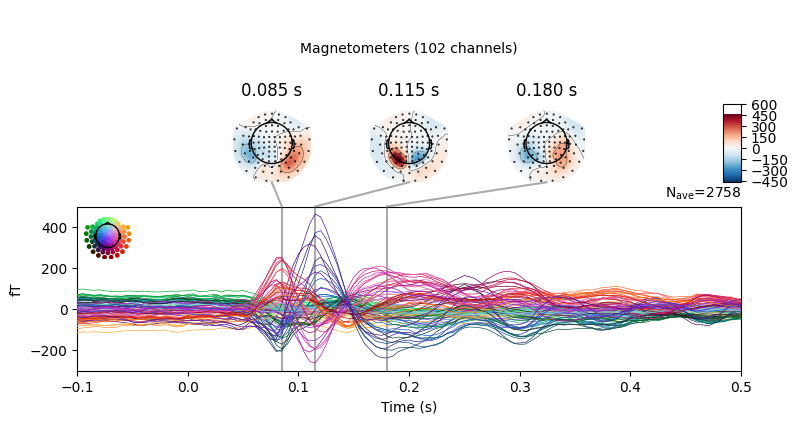

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


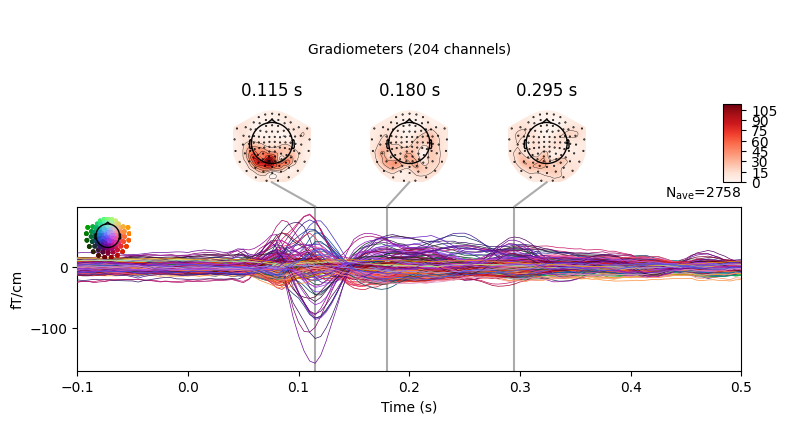

[<Figure size 800x420 with 7 Axes>, <Figure size 800x420 with 7 Axes>]

In [5]:
epochs.average().plot_joint()

We need to equalize event count in order to make use of the default crossvalidation scheme in rsatoolbox for the crossnobis calculations. Alternatively, we could also devise another crossvalidation scheme for which we might choose not to equalize event count.

In [6]:
epochs.equalize_event_counts()

Dropped 90 epochs: 930, 1478, 1479, 1480, 1481, 1482, 1486, 1492, 1493, 1499, 1504, 1505, 1518, 1520, 1521, 1525, 1539, 1657, 1659, 1669, 1709, 1713, 1730, 1742, 1743, 1745, 1749, 1752, 1754, 1757, 1758, 1761, 1763, 1768, 1770, 1771, 1772, 1774, 1777, 1778, 1779, 1780, 1781, 1782, 1784, 1785, 1787, 1788, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1798, 1800, 1803, 1805, 1806, 1807, 1808, 1810, 1812, 1814, 1815, 1817, 1818, 1819, 1820, 1821, 1823, 1824, 1825, 1826, 1827, 1830, 1831, 1832, 1833, 1836, 1837, 1838, 1946, 1959, 2001, 2007, 2011, 2013, 2016


(<Epochs |  2668 events (all good), -0.1 – 0.5 s, baseline off, ~760.0 MB, data loaded,
  '0/human bodypart/human/not-face/animal/natural': 29
  '1/human bodypart/human/not-face/animal/natural': 29
  '2/human bodypart/human/not-face/animal/natural': 29
  '3/human bodypart/human/not-face/animal/natural': 29
  '4/human bodypart/human/not-face/animal/natural': 29
  '5/human bodypart/human/not-face/animal/natural': 29
  '6/human bodypart/human/not-face/animal/natural': 29
  '7/human bodypart/human/not-face/animal/natural': 29
  '8/human bodypart/human/not-face/animal/natural': 29
  '9/human bodypart/human/not-face/animal/natural': 29
  and 82 more events ...>,
 array([1823, 1493, 1713, 1780, 1774, 1768, 1832, 1742, 1777, 1521,  930,
        1492, 1525, 1795, 1758, 1657, 1791, 1831, 1810, 1819, 1808, 1730,
        1803, 1763, 2007, 1821, 1479, 1520, 1778, 1782, 1504, 1781, 1787,
        1824, 1499, 2011, 1478, 1793, 1820, 1784, 1798, 2013, 1757, 1749,
        1827, 1669, 1814, 1743, 1745, 2

In [7]:
# only using magnetometers for this example
picks = ['mag']

# dimension labels
ch_names = [ch_name for ch_name, ch_type in zip(epochs.ch_names, epochs.get_channel_types()) if ch_type in picks]
event_ids = epochs.event_id
times = epochs.times

n_events, n_channels, n_times = epochs.get_data(picks=picks).shape

# get condition name per event
rev_event_id = {v: k for k, v in epochs.event_id.items()}
event_names = np.array([rev_event_id[i] for i in epochs.events[:, 2]])

### 1b) simulate multiple subjects

We will simulate multiple subjects as noisy versions of the one subject

1) We will first compute the noise precision matrix and the condition averages for one subject
2) We then create simulated subjects

#### compute channel noise precision matrix for single subject

compute residuals by subtracting repition-averaged timecourses

In [8]:
residuals = np.zeros_like(epochs.get_data(picks=picks))

# loop over event_id and compute residuals
for event_id, trigger in epochs.event_id.items():
    events_data = epochs[event_id].get_data(picks=picks) # n_repetitions x n_channels x n_times    
    residuals[event_id == event_names, :, :] = events_data - np.mean(events_data, axis=0, keepdims=True)

print(f'{residuals.shape=} = (n_events, n_channels, n_timepoints)')

residuals.shape=(2668, 102, 121) = (n_events, n_channels, n_timepoints)


compute precision matrix - we collapse timepoints and events into one dimension

In [9]:
reshaped_residuals = np.swapaxes(residuals, 1, 2).reshape(-1, n_channels)
print(f'{reshaped_residuals.shape=} = (n_events * n_timepoints, n_channels)')

prec = rsatoolbox.data.prec_from_residuals(reshaped_residuals, method='shrinkage_diag')
print(f'{prec.shape=} = (n_channels, n_channels)')

reshaped_residuals.shape=(322828, 102) = (n_events * n_timepoints, n_channels)
prec.shape=(102, 102) = (n_channels, n_channels)


#### compute condition averages for single subject

In [10]:
averaged_epochs = np.zeros((len(epochs.event_id), n_channels, len(epochs.times)))

for ii,(event_id, trigger) in enumerate(epochs.event_id.items()):
    averaged_epochs[ii, :, :] = epochs[event_id].average().get_data(picks=picks)

print(f'{averaged_epochs.shape=} = (n_conditions, n_channels, n_timepoints)')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

#### simulate multiple subjects

In [11]:
n_subjects = 7
noise = .1 # as multiple of np.std(averaged_epochs)

In [12]:
data_sd = averaged_epochs.std()
group_data = [epochs.get_data(picks=picks) + np.random.randn(*epochs.get_data(picks=picks).shape) * noise * data_sd for _ in range(n_subjects)]
print(f'{len(group_data)=} = (n_subjects) each element is a {group_data[0].shape=} = (n_conditions, n_channels, n_timepoints)')

# we'll just use the same precision noise matrix for all subjects for this example
group_prec_matrix = [prec] * n_subjects
print(f'\n{len(group_prec_matrix)=} = (n_subjects), each element is a {group_prec_matrix[0].shape=} = (n_channels, n_channels) matrix')

len(group_data)=7 = (n_subjects) each element is a group_data[0].shape=(2668, 102, 121) = (n_conditions, n_channels, n_timepoints)

len(group_prec_matrix)=7 = (n_subjects), each element is a group_prec_matrix[0].shape=(102, 102) = (n_channels, n_channels) matrix


## 2 import data into rsa toolbox

We import the events (not the averaged epochs) into the RSA toolbox here. This is because we compute the crossvalidated mahalanobis distance which requires crossvalidation.

In [13]:
# parse the factor levels
image_index = np.array([int(event_name.split('/')[0]) for event_name in event_names])
condition = np.array([event_name.split('/')[1] for event_name in event_names])
human = np.array([event_name.split('/')[2] for event_name in event_names])
face = np.array([event_name.split('/')[3] for event_name in event_names])
animal = np.array([event_name.split('/')[4] for event_name in event_names])
natural = np.array([event_name.split('/')[5] for event_name in event_names])

In [14]:
des = {'session': 0}                        # some (made up) metadata, we could also append data session-wise and crossvalidate across sessions ...
                                            # ... but we'll just pretend all data came from one session and crossvalidate across image category repetitions

obs_des = dict(                             # observation descriptors
                image_index=image_index,    # image index
                condition=condition,        # image category
                human=human,                # human vs not-human
                face=face,                  # face vs not-face
                animal=animal,              # animal vs not-animal
                natural=natural             # natural vs not-natural
                )

chn_des = {'channels': ch_names}            # channel descriptors

tim_des = {'time': times}                   # time descriptor


data = []
for i, subject_data in enumerate(group_data):
    des['subject'] = i
    data.append(rsatoolbox.data.TemporalDataset(subject_data,
                                descriptors = des,
                                obs_descriptors = obs_des,
                                channel_descriptors = chn_des,
                                time_descriptors = tim_des))
    data[-1].sort_by('image_index')

## 3 compute RDM movie

In [15]:
descriptor = 'image_index'
rdms_data = rsatoolbox.rdm.calc_rdm_movie(
    data, # list of length n_subjects
    method = 'crossnobis',
    descriptor = descriptor,
    noise = group_prec_matrix # list of len(data)
)
print(rdms_data.dissimilarities.shape)
print(f'{rdms_data.dissimilarities.shape=} = (n_subjects * n_timepoints, n_conditions * (n_conditions-1) / 2)')

(847, 4186)
rdms_data.dissimilarities.shape=(847, 4186) = (n_subjects * n_timepoints, n_conditions * (n_conditions-1) / 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'data RDM movie and individual dissimilarity trajectories')

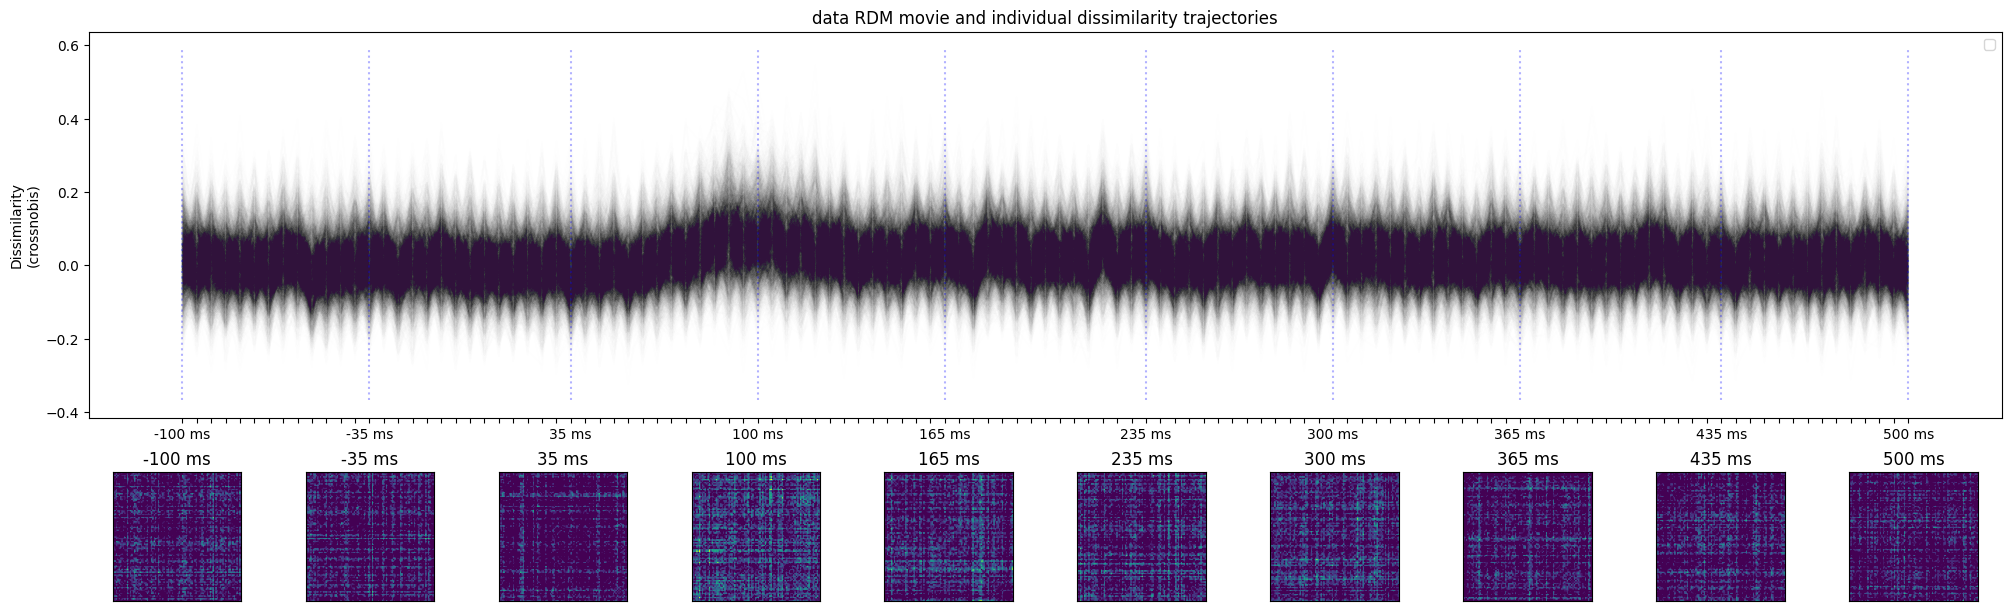

In [16]:
fig, ax = plot_timecourse(
    rdms_data, 
    descriptor, 
    n_t_display=10, 
    fig_width=20,
    colored_conditions=None,
)
ax[0].set_title('data RDM movie and individual dissimilarity trajectories')

Text(0.5, 1.0, 'data RDM movie, dissimilarity trajectories grouped by face/not-face')

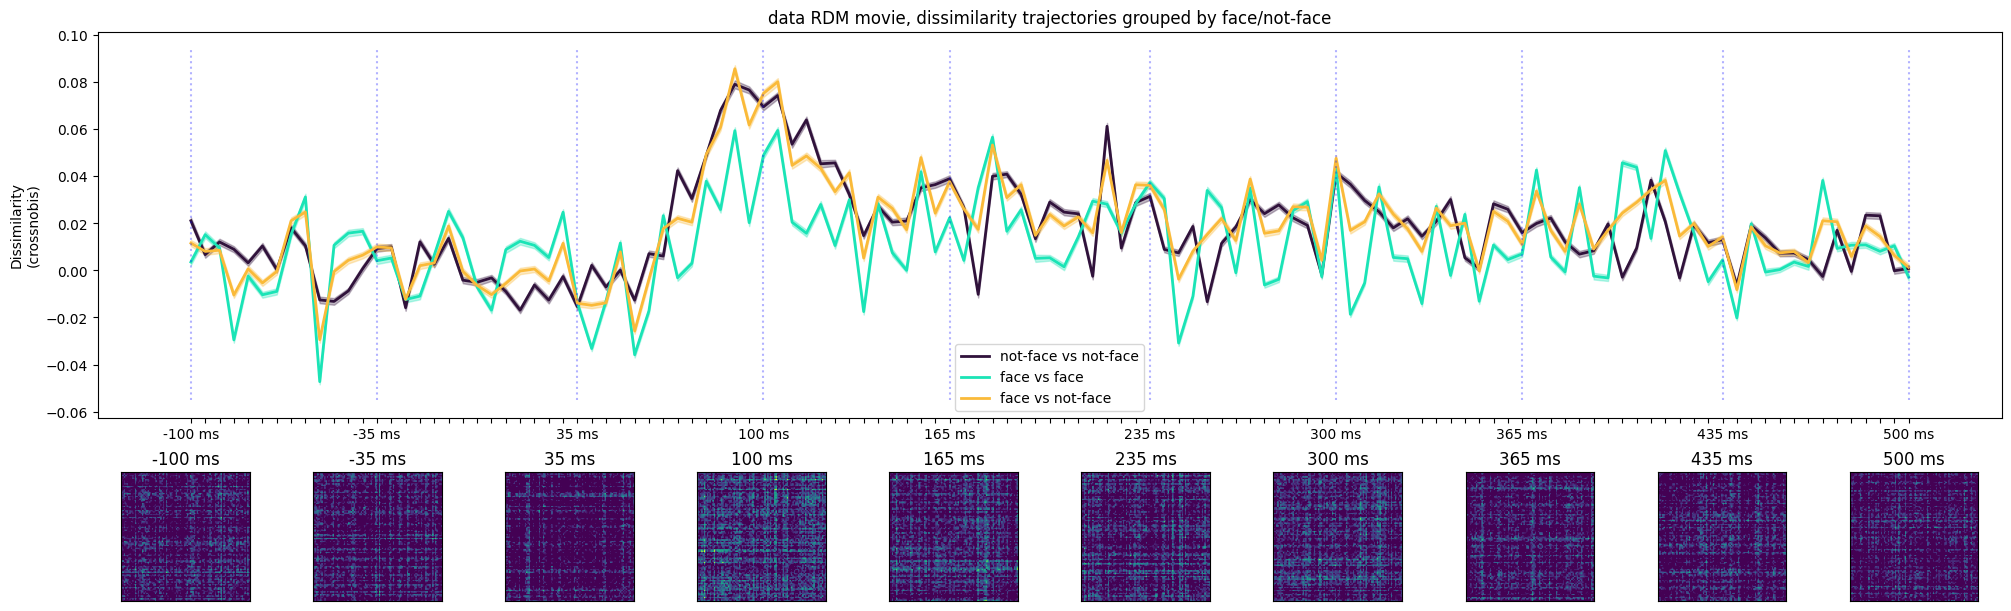

In [17]:
face = np.array([event_name.split('/')[3] for event_name in conditions])
fig, ax = plot_timecourse(
    rdms_data, 
    descriptor, 
    n_t_display=10, 
    fig_width=20,
    colored_conditions=face
)
ax[0].set_title('data RDM movie, dissimilarity trajectories grouped by face/not-face')

Text(0.5, 1.0, 'data RDM movie, dissimilarity trajectories grouped by natural/non-natural')

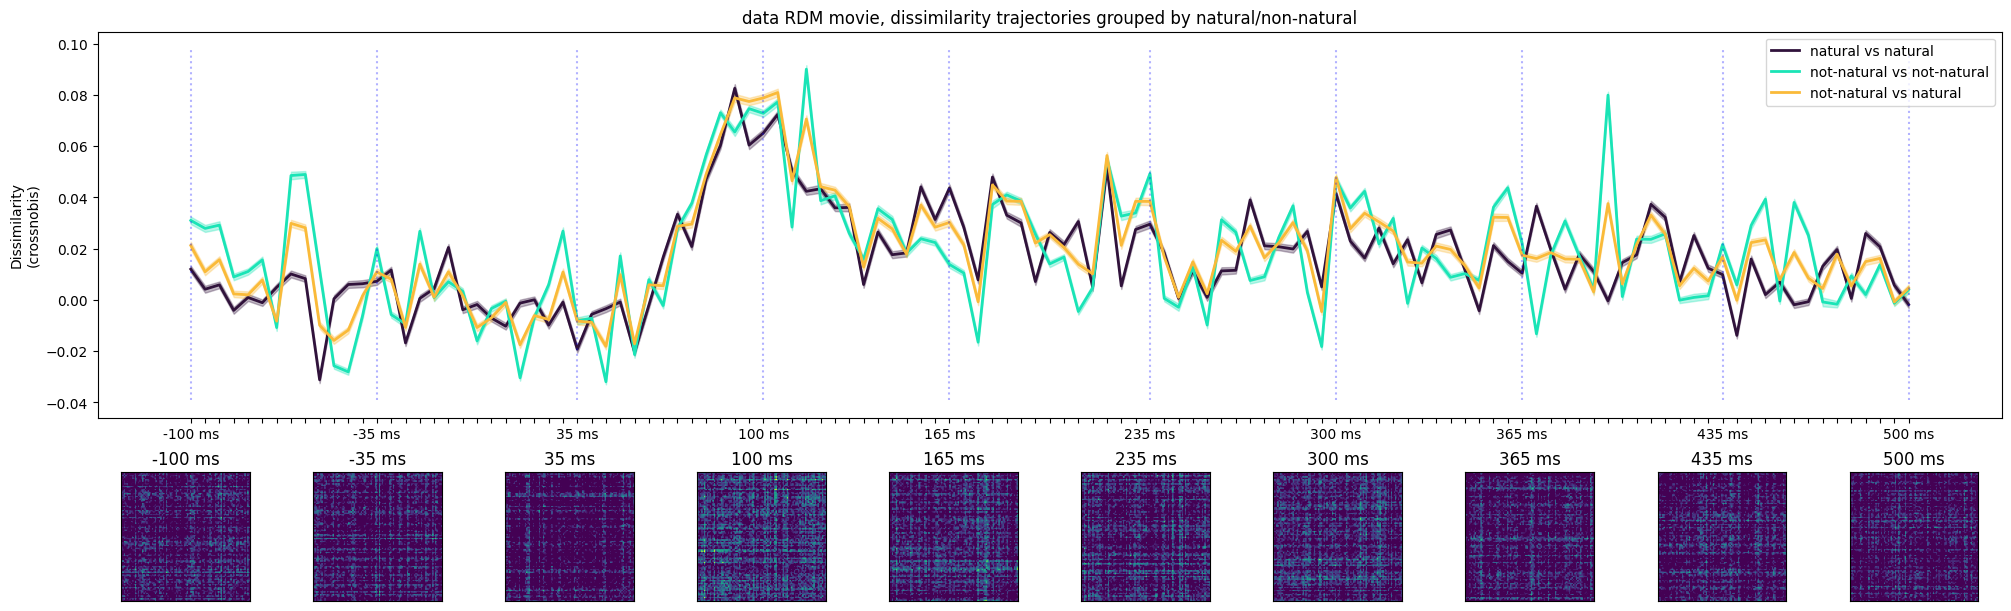

In [18]:
natural = np.array([event_name.split('/')[5] for event_name in conditions])
fig, ax = plot_timecourse(
    rdms_data, 
    descriptor, 
    n_t_display=10, 
    fig_width=20,
    colored_conditions=natural
)
ax[0].set_title('data RDM movie, dissimilarity trajectories grouped by natural/non-natural')

## 4 evaluate RDM movie similarity to model RDMs

### define candidate model RDMs

In [19]:
image_index = np.array([int(event_name.split('/')[0]) for event_name in conditions])
condition = np.array([event_name.split('/')[1] for event_name in conditions])
human = np.array([event_name.split('/')[2] for event_name in conditions])
face = np.array([event_name.split('/')[3] for event_name in conditions])
animal = np.array([event_name.split('/')[4] for event_name in conditions])
natural = np.array([event_name.split('/')[5] for event_name in conditions])

For this example, we'll just look at two RDMs.
- A categorical RDM that encodes face-ness
- A categorical RDM that encodes natural-ness

In [20]:
face_notface_rdm = rsatoolbox.rdm.get_categorical_rdm([1 if i=='face' else 0 for i in face], 'face_notface')
face_notface_model = rsatoolbox.model.ModelFixed('face_notface', face_notface_rdm)

natural_notnatural_rdm = rsatoolbox.rdm.get_categorical_rdm([1 if i=='natural' else 0 for i in natural], 'natural_notnatural')
natural_notnatural_model = rsatoolbox.model.ModelFixed('natural_notnatural', natural_notnatural_rdm)

let's display the two model RDMs

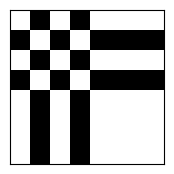

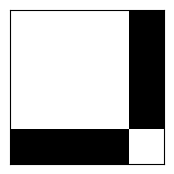

In [21]:
rsatoolbox.vis.show_rdm(face_notface_rdm)
rsatoolbox.vis.show_rdm(natural_notnatural_rdm);

In [22]:
model_names = ['face_notface', 'natural_notnatural']
models = [face_notface_model, natural_notnatural_model]

We chose cosine similarity for the crossnobis-RDMs

In [23]:
results = rsatoolbox.inference.eval_fixed(models, rdms_data, method='cosine')
print(f'{results.evaluations.shape=} = (n_bootstrap_samples, n_models, n_timepoints * n_subjects)')

results.evaluations.shape=(1, 2, 847) = (n_bootstrap_samples, n_models, n_timepoints * n_subjects)


## 5 compute cluster-based permutation statistic


timepoints and subjects are packed into the last dimension of results.evaluations

the util function num_index together with the rdm_descriptors from the rdms_data will help us indexing the correct elements

In [24]:
from rsatoolbox.util.descriptor_utils import num_index
print(f'{rdms_data.rdm_descriptors.keys() = }')

# get indices for the first timepoint in the last dimension of results.evaluations
print(f'\n{num_index(rdms_data.rdm_descriptors["time"], times[0]) = }')

# we reshape the evaluations to get a (n_models, n_subjects, n_timepoints) array
evaluations_reshaped = np.concatenate([results.evaluations[0][:, num_index(rdms_data.rdm_descriptors['time'], time)][:, :, np.newaxis] for time in np.unique(times)], axis=2)
print(f'\n{evaluations_reshaped.shape = }')

rdms_data.rdm_descriptors.keys() = dict_keys(['session', 'subject', 'index', 'time'])

num_index(rdms_data.rdm_descriptors["time"], times[0]) = array([  0, 121, 242, 363, 484, 605, 726])

evaluations_reshaped.shape = (2, 7, 121)


evaluations_mean.shape=(2, 121)
evaluations_sem.shape=(2, 121)


Text(0.5, 0, 'time')

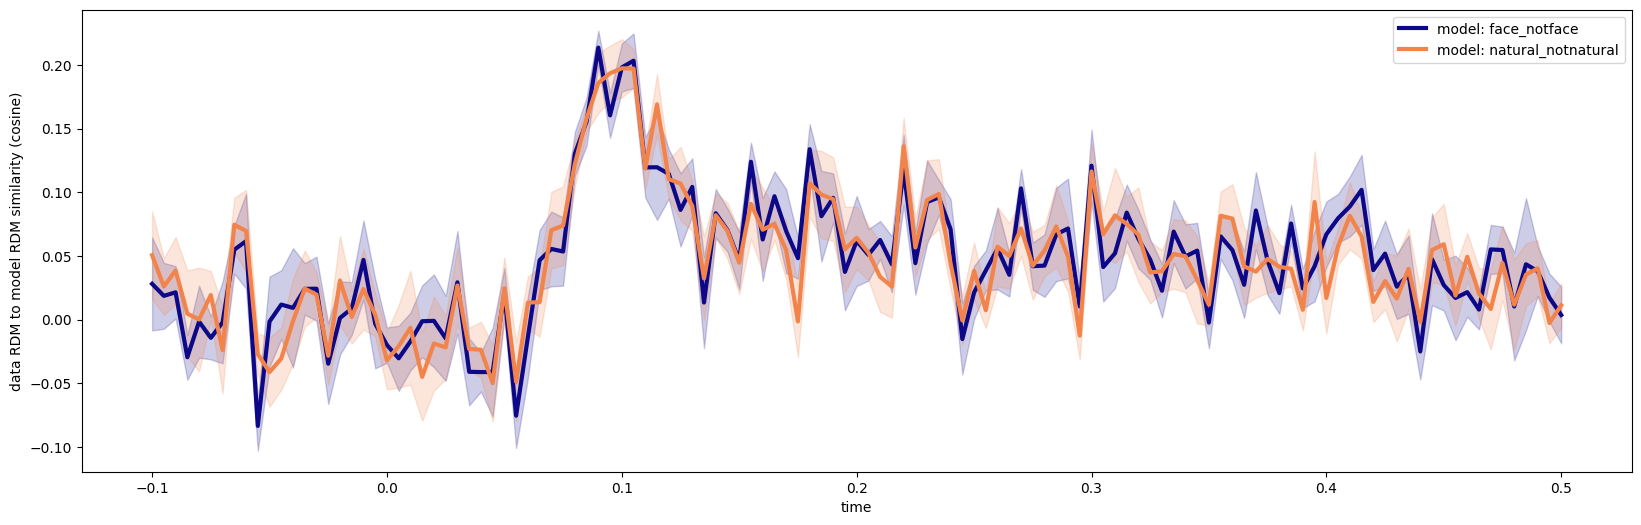

In [25]:
# mean and sem across subjects
evaluations_mean = np.mean(evaluations_reshaped, axis=1).squeeze()
evaluations_sem = np.std(evaluations_reshaped, axis=1).squeeze() / np.sqrt(evaluations_reshaped.shape[1])

print(f'{evaluations_mean.shape=}')
print(f'{evaluations_sem.shape=}')

fig, ax = plt.subplots(1,1, figsize=(20,6))
colors = plt.get_cmap('plasma')(np.linspace(0., .7, len(model_names)))
for i, (ev,sem) in enumerate(zip(evaluations_mean, evaluations_sem)):
    ax.fill_between(np.unique(times), ev-sem, ev+sem, color=colors[i], alpha=.2)
    ax.plot(np.unique(times), ev, color=colors[i], label=f"model: {model_names[i]}", linewidth=3)
ax.legend()
ax.set_ylabel('data RDM to model RDM similarity (cosine)')
ax.set_xlabel('time')

In [26]:
def plot_contrast_stats(data, statistic, clusters, cluster_p_values, H0, model_names):
        
    T = np.unique(times)
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    
    mn, se = data[0].mean(axis=0)-data[1].mean(axis=0), (data[0]-data[1]).std(axis=0) / np.sqrt(data.shape[0])
    ax.fill_between(T,mn-se,mn+se)
    ax.plot(T, mn, 
            label=f"{model_names[0]} vs {model_names[1]}")
        
    ax.set_ylabel("difference in data-model similarity")
    ax.legend()
    
    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:            
            h = ax2.axvspan(T[c[0]], T[c[-1]],
                            color='r', alpha=0.3)
    ax2.plot(T, statistic, 'g')
    if h is not None:
        ax2.legend((h, ), ('cluster p-value < 0.05', ))
    ax2.set_xlabel("time")
    ax2.set_ylabel("f-values")
    
    return fig, (ax, ax2)
    
def plot_condition_stats(data, statistic, clusters, cluster_p_values, H0, model_name, axes=None):
        
    T = np.unique(times)
    if axes is None:
        fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
    else:
        ax, ax2 = axes
        fig = ax.get_figure()
    
    mn, se = data.mean(axis=0), data.std(axis=0) / np.sqrt(data.shape[0])
    ax.fill_between(T,mn-se,mn+se)
    ax.plot(T, mn, label=f"{model_name}")
    ax.set_ylabel("data-model similarity")
    ax.legend()
    
    h = None
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:            
            h = ax2.axvspan(T[c[0]], T[c[-1]],
                            color='r', alpha=0.3)
    ax2.plot(T, statistic, 'g')
    if h is not None:
        ax2.legend((h, ), ('cluster p-value < 0.05', ))
    ax2.set_xlabel("time")
    ax2.set_ylabel("f-values")    
    return fig, (ax, ax2)

stat_fun(H1): min=0.000009 max=4.266581
Running initial clustering …
Found 30 clusters


/Users/jasper/projects/rsatoolbox/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 1023/1023 [00:00<00:00, 10964.65it/s]


Text(0.5, 1.0, 'face_notface vs natural_notnatural')

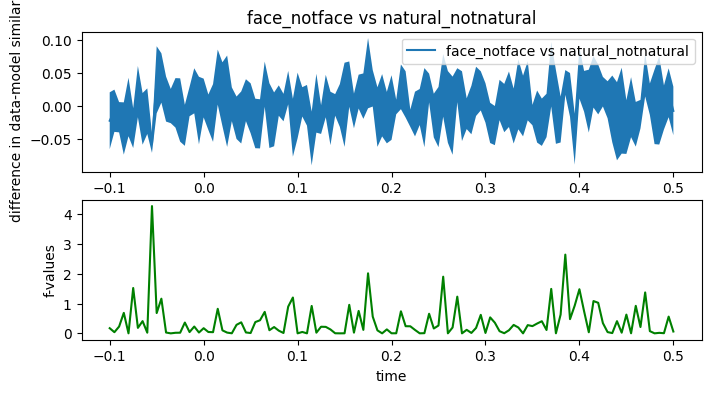

In [27]:
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(evaluations_reshaped, threshold=.05)

fig, ax = plot_contrast_stats(evaluations_reshaped, F_obs, clusters, cluster_p_values, H0, model_names)
ax[0].set_title(f'{model_names[0]} vs {model_names[1]}')

stat_fun(H1): min=-3.965374 max=14.891419
Running initial clustering …
Found 20 clusters


100%|██████████| Permuting (exact test) : 63/63 [00:00<00:00, 4434.10it/s]

stat_fun(H1): min=-1.542347 max=14.178679
Running initial clustering …
Found 22 clusters



100%|██████████| Permuting (exact test) : 63/63 [00:00<00:00, 4541.55it/s]


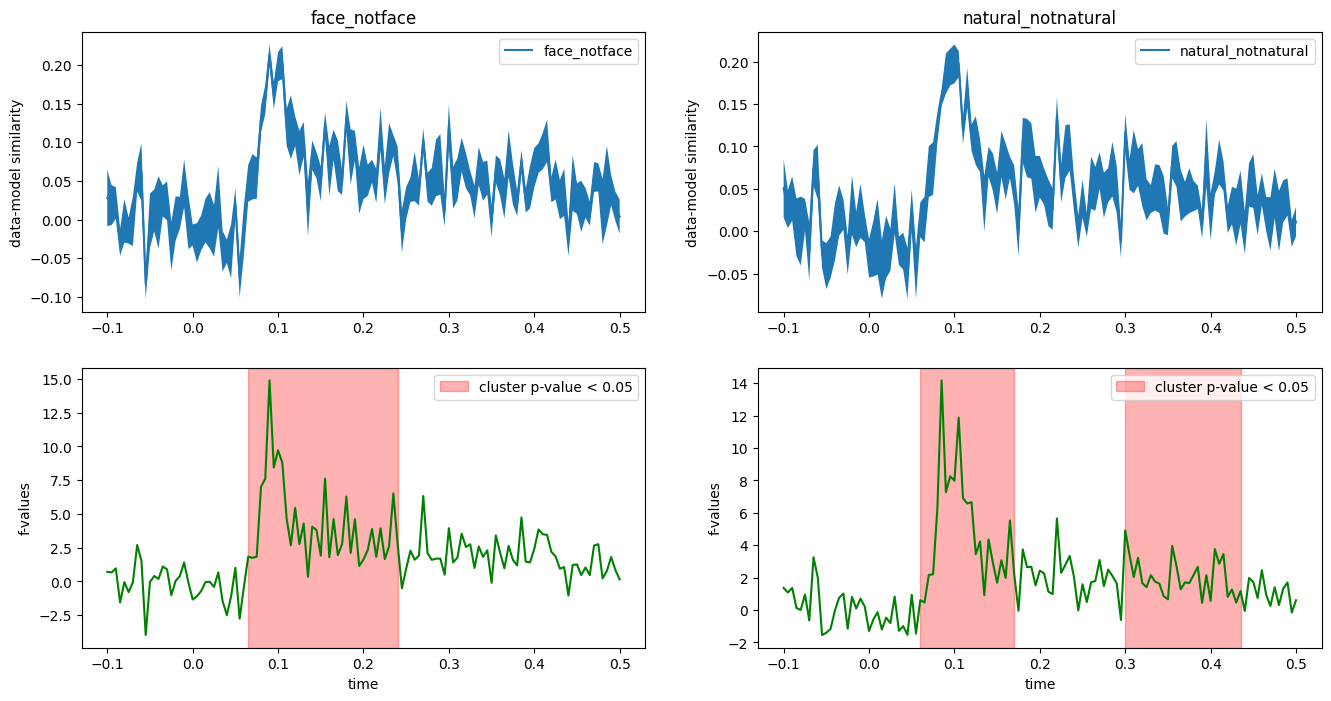

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for model_name, data, ax in zip(model_names, evaluations_reshaped, axes.T):
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(data, threshold=.05)
    plot_condition_stats(data, T_obs, clusters, cluster_p_values, H0, model_name, axes=ax)
    ax[0].set_title(model_name)